In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import pathlib
from soilgasflux_fcs import json_reader
import scipy.optimize as op
from lmfit import Model

/Users/alexnaokiasatokobayashi/opt/anaconda3/envs/Peat/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data_path = pathlib.Path('../data/synthetical/data62/test')
a = json_reader.Initializer(folderPath=data_path)
df = a.prepare_rawdata()
for i in df['id'].unique():
    df_i = df[df['id'] == i]

KeyError: 'curvature'

In [12]:
def target_function(t, cx, a, c0):
    e = 2.71828
    return cx+(c0-cx)*e**(-a*(t))

In [13]:
df_i.head()

,datetime,datetime_utc,k30_co2,bmp_pressure,bmp_temperature,si_humidity,si_temperature,id,timedelta,alpha,c_s,c_c0,deadband,disturbance_intensity,disturbance_starting_point,add_noise
0,2025-03-24 19:05:27,2025-03-24 19:05:27,429.603584,99000.0,20.0,70.0,20.0,2025-3-24_19-5-27,0,0.000175,1000.0,430,0,0,0,True
1,2025-03-24 19:05:28,2025-03-24 19:05:28,430.634185,99000.0,20.0,70.0,20.0,2025-3-24_19-5-27,1,0.000175,1000.0,430,0,0,0,True
2,2025-03-24 19:05:29,2025-03-24 19:05:29,430.138442,99000.0,20.0,70.0,20.0,2025-3-24_19-5-27,2,0.000175,1000.0,430,0,0,0,True
3,2025-03-24 19:05:30,2025-03-24 19:05:30,430.154989,99000.0,20.0,70.0,20.0,2025-3-24_19-5-27,3,0.000175,1000.0,430,0,0,0,True
4,2025-03-24 19:05:31,2025-03-24 19:05:31,431.511398,99000.0,20.0,70.0,20.0,2025-3-24_19-5-27,4,0.000175,1000.0,430,0,0,0,True


In [14]:
fmodel = Model(target_function)
c0 = 430
params = fmodel.make_params(cx=c0, a=1, c0=c0)
params['c0'].vary = False
params['a'].min=0

result = fmodel.fit(df_i['k30_co2'].values, params, t=df_i['timedelta'].values)
result

In [67]:
def lnlike(theta, t, y, yerr):
    cx, a, lnf = theta
    model = cx + (430-cx)*2.71828**(-a*(t))
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    cx, a, lnf = theta
    cx_bf = 1770
    a_bf = 7e-5 
    if cx_bf*0.1 < cx < cx_bf*10 and 0 < a < a_bf*10 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

# def lnprob(theta, t, y, yerr, cx_bf, a_bf):
def lnprob(theta, t, y, yerr):
   
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, t, y, yerr)

In [77]:
ndim, nwalkers = 3, 100
pos = np.array([[result.params['cx'].value], [result.params['a'].value], [1]]).reshape(1,3)+1e-4*np.random.randn(nwalkers, ndim)
# pos

In [78]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(df_i['timedelta'].values, 
                                                              df_i['k30_co2'].values, 
                                                              np.ones(len(df_i['k30_co2'].values))*0.5, 
                                                            #   result.params['cx'].value, 
                                                            #   result.params['a'].value)
                                                              ))

In [95]:
sampler.run_mcmc(pos, 1000)

/Users/alexnaokiasatokobayashi/opt/anaconda3/envs/Peat/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


State([[ 1.33272833e+03  1.09266729e-04 -8.47773960e+00]
 [ 1.62888812e+03  8.29919133e-05 -8.08699859e+00]
 [ 2.32083156e+03  5.23481829e-05 -9.56599990e+00]
 [ 1.29188666e+03  1.14775517e-04 -8.28094903e+00]
 [ 1.73460474e+03  7.58883823e-05 -9.69895669e+00]
 [ 1.48030017e+03  9.39786126e-05 -8.33909078e+00]
 [ 1.54596421e+03  8.90720024e-05 -8.45229497e+00]
 [ 1.29170373e+03  1.16002377e-04 -8.19269282e+00]
 [ 1.36664243e+03  1.05487830e-04 -8.02382459e+00]
 [ 1.68965454e+03  7.84799612e-05 -8.02479453e+00]
 [ 2.36408773e+03  5.07487500e-05 -9.29658854e+00]
 [ 1.57728376e+03  8.64685336e-05 -9.28333340e+00]
 [ 1.73882222e+03  7.58192636e-05 -9.04144025e+00]
 [ 1.34909786e+03  1.08131119e-04 -8.80025702e+00]
 [ 2.19767522e+03  5.59353915e-05 -8.73348448e+00]
 [ 1.94733909e+03  6.51772381e-05 -8.32979400e+00]
 [ 1.66154827e+03  8.01625352e-05 -8.26860914e+00]
 [ 2.05762218e+03  6.08540200e-05 -8.77138862e+00]
 [ 1.37745736e+03  1.04471743e-04 -7.96420538e+00]
 [ 1.47192920e+03  9.4668

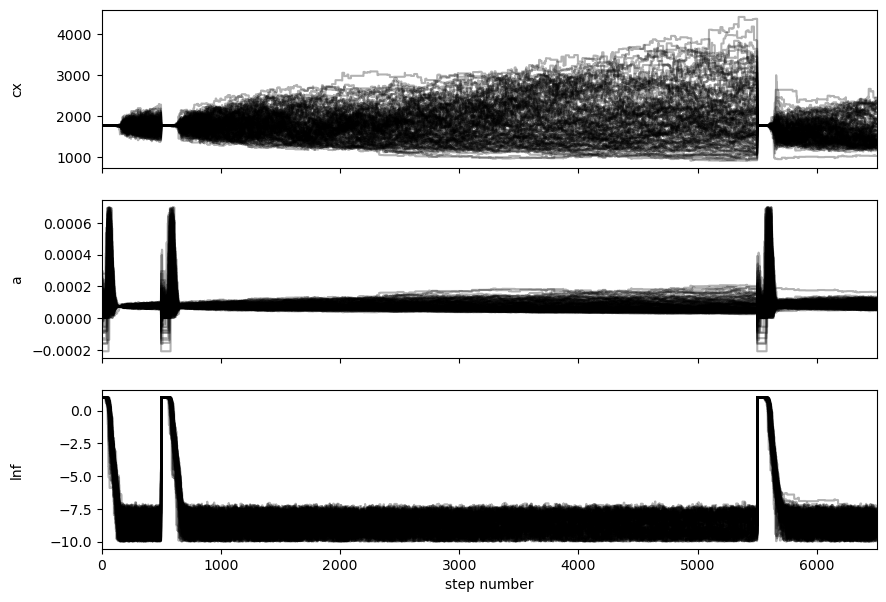

In [96]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["cx", "a", "lnf"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [97]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
print(flat_samples.shape)

(40000, 3)


In [94]:
flat_samples

array([[ 1.76820631e+03,  9.37883483e-05,  9.99483891e-01],
       [ 1.76820646e+03,  1.14815655e-04,  1.00028450e+00],
       [ 1.76820656e+03,  5.15156140e-05,  9.99885820e-01],
       ...,
       [ 3.44749588e+03,  3.26607074e-05, -8.09960444e+00],
       [ 1.55022990e+03,  8.82424314e-05, -9.40540173e+00],
       [ 9.89999580e+02,  1.78519784e-04, -7.97264615e+00]])

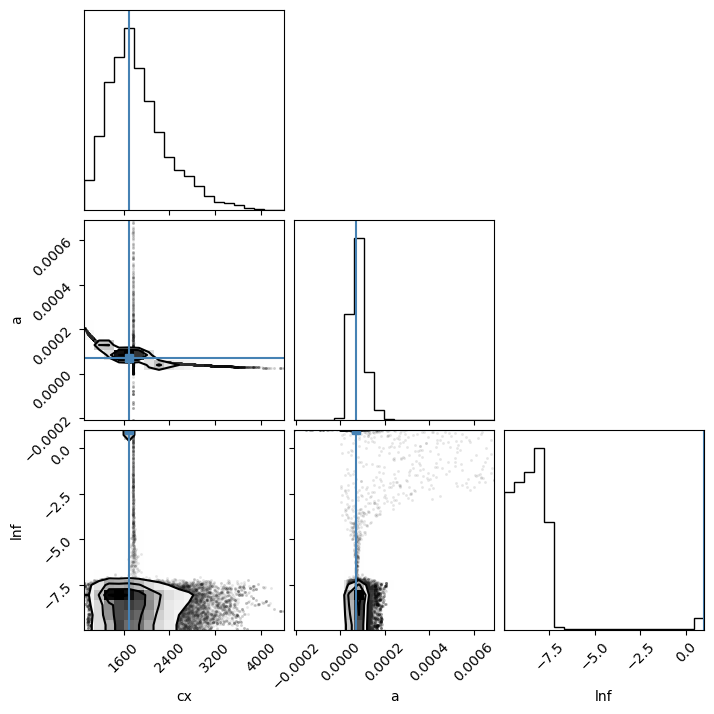

In [93]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[1700, 7e-5 , 1]
);